## What is transfoer learning?

Trainsfer learning allows us to take the patterns(also called weights) another model has learned from another problem and use them for our own problem.

The premis is: find a well-performing existing model and apply it to your own problem.

For example: we can take patterns a computer vision model ahs learned from datasets usch as imageNet and use them to power out FoodVision model.

## Why ues transfoer learning?

Two main benefits:
1. Can leverage an existing model proven to wrok on problems similar to our own.
2. Can leverage a working model which has already learend patternson similar data to our own. This often results in achieveing great results with less custom data.

## Where to find pretrained models?

1. PyTorch domain libraries
2. HuggingFace Hub
3. timm (PyTorch Image Models library)
4. Paperswithcode

## 0. Getting setup



In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Install torchinfo cuz it does not came with PyTorch
try:
  from torchinfo import summary
except:
  print(f"torchinfo not found... intralling...")
  !pip install -q torchinfo
  from torchinfo import summary

torchinfo not found... intralling...


In [2]:
# import moduels from 05_pytorch.ipynb so I do not have to write it again
try:
  from going_modular.going_modular import data_setup, engine
except:
  print(f"going_modular not imported... importing...")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

going_modular not imported... importing...
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 24.03 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


I could not download from my own directory becuase I have a Python file that makes 5 differetn .py files and the thing above is a folder with a fodler with each of the 5 .py files separately

In [3]:
# device agnostics
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [4]:
# Donwload the pizza_steak_sushi.zio
import os
import zipfile
import requests

from pathlib import Path

# Set up data foler
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image does not exists
if image_path.is_dir():
  print(f"{image_path} is a direcotry already :)")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
      request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
      print("Downloading pizza, steak, sushi data...")
      f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi data...")
      zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Satasets and DataLoaders

Since we downloaded the `going_modular` dir, we can use the `data_setup.py` to create DataLoaders.

BUt since we'll be using pretrained model from `torchvision.models`, there;s a specific tranfomr we need to prepare our images first.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

When using a pretrained model, it;s important that **your custom data going into the model is prepared in the same way as the original training data that went into the model.**

The formal is:
1. Mini-batch of size `[batch_size, 3, height, width]`, where h adn w are at least 244x244
2. Values between 0 & 1
3. A mean of `[0.485, 0.456, 0.406]`
4. A sd of `[0.229, 0.224, 0.225]`

Some models might take `[3, 240, 240]` **always check documentation**.

The mean and sd were calcualted from the ImageNet dataset by taking the means and sd across a subset of images. It is not necessary as nn can calculate them but it helps achive better performence quicker.

In [6]:
# Create a transform pipline manually(required for torchvision < 0.13)
manual_transforms = transforms.Compose(
    [
        transforms.Resize((244,244)), # 1. Reshape all images to 244x244
        transforms.ToTensor(), # 2, Turn images value to between 0 & 1
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                            std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
    ]
)

Note: I've included this manual creation of transforms in this notebook because you may come across resources that use this style. It's also important to note that because these transforms are manually created, they're also infinitely customizable. So if you wanted to included data augmentation techniques in your transforms pipeline, you could.

In [7]:
BATCH_SIZE = 32
# Create training and testing DataLoaders as well as get a list of class names using the going_modular folder
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=BATCH_SIZE) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7aceb0e2e830>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transfomr for `torchvison.models` (auto creation)

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model.**

AS of `torchvision` v0.13+, an automatic transfomr creating feature has been added. When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, we would say:

**weight = torchvision.models.EfficientNet_B0_Weights.DEAFULT**

Where,
* EfficientNet_B0_Weights -> model architecture
* DEAFULT -> the best avaiable weight(best performence)



In [8]:
# Get a set of pretrainde model wieght
weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weight

EfficientNet_B0_Weights.IMAGENET1K_V1

Now to access the transfomrs assosiated with out `weights`, we can use the `transforms()` moethod.

This is essentially saying "get the data transforms that were used to train the EfficientNet_B0_Weights on ImageNet".

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weight.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

The benefit of automatically creating a transfrm is that you ensure you are using the same data transfomrmation as the pretraind model. However, the trade of is lack of customization.

In [10]:
BATCH_SIZE = 32
# Create training and testing DataLoaders as well as get a list of class names with auto transform
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=BATCH_SIZE) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7acf8bccceb0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrainde model

The whole idea of transfer learning is to take an already well-performing model on a problem space similar to yours and then customising it to your use case.

You can find many common computer vision achitecture backbones on `torchvision.models`

### 3.1 Which pretrained model should you use?

Generally the higher the number in the model name the better(better performence but a larger model)

**Some better performing models are too big for some devices(phones).**

Understanding this **performance vs. speed vs. size tradeoff** comes with time and practice.

 Best to experiment, experiment, experiment and see what works for your problem.


### 3.2 Setting up a pretrained model



In [11]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
#model = torchvision.models.efficientnet_b0(weights=weights)

#model # uncomment to output (it's very long)

The code above fails hash check so we have to remove it, if its fixed the code above will work.

In [12]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# All 3 below give the same thing
#efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
#efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
#efficientnet_b0(weights="DEFAULT")

model = efficientnet_b0(weights="DEFAULT")
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 47.7MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

The model cames in three mian parts:

1. `features` - a collection of conv layers and other various activation layers to learn a base represnetation of vision data
2. `avgpool` - takes the average of the output of the `features` layers and turns in into a **features vector**
3. `classifier` - turns the feature vector into a vector with the same dim as the number of required output classes(deafult out_features=1000 becasue ImageNet has 1000 classes)

### 3.3 Gettting a summary of our model wiht `torchinfo`

In [13]:
# print out a summary using torchinos
summary(model=model,
        input_size=(32, 3, 244,244),
        # col_names = ["input_size"],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 244, 244]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 244, 244]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 244, 244]    [32, 32, 122, 122]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 244, 244]    [32, 32, 122, 122]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 122, 122]   [32, 32, 122, 122]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 122, 122]   [32, 32, 122, 122]   --                   --
│    └─Sequential (1)                                        [32, 32, 122, 122]   [32, 16, 122

### 3.4 Freezing the base model and chaning the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

We need out_feautres = 3 and the model has out_features = 1000.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_gra=False`. (For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.)

In [14]:
# Freeze all base laeyrs in the features section of the model
for param in model.features.parameters():
  param.requires_grad = False

In [15]:
# Set the manula seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the len of the class_names( ont output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), # remove connection between tow nn layers with probability p
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [16]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

We can see few changes:

1. Trainable column - Many of the base layers have their Trainable values as False. This is beacsuse we set their attribute `requires_grad=False`. Unless we change this, there layers won't be updated during feature training.
2. OUtput shape of `classifier` - The classifier portion of the model now has Output Shape value of [32, 3] insted of [32, 1000]. It's Trainable value is also True. This means its parametrs will be updated during trainig. In essecne, we're using the features portion to feed our classifier portion a base representation of an image and the our classifer layer is going to learn how to base repsentation aligns with our problem.
3. Less trainable parameters - Previousl there were 5 mil + trainable paramenters. but since we froze many of the layers of the model and only left classigier trainable, there is now only 3,843 trainable parameters.

## 4. Train model

In [17]:
LR = 0.001
# Define loss and potimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LR)

Train function from the going modular folder on github

In [18]:
# Set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# end timer and print our restuls
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Total training time: 12.631 seconds


## 5. Evaluate modl by plotting loss curves

Couldn't find helper_functions.py, downloading...


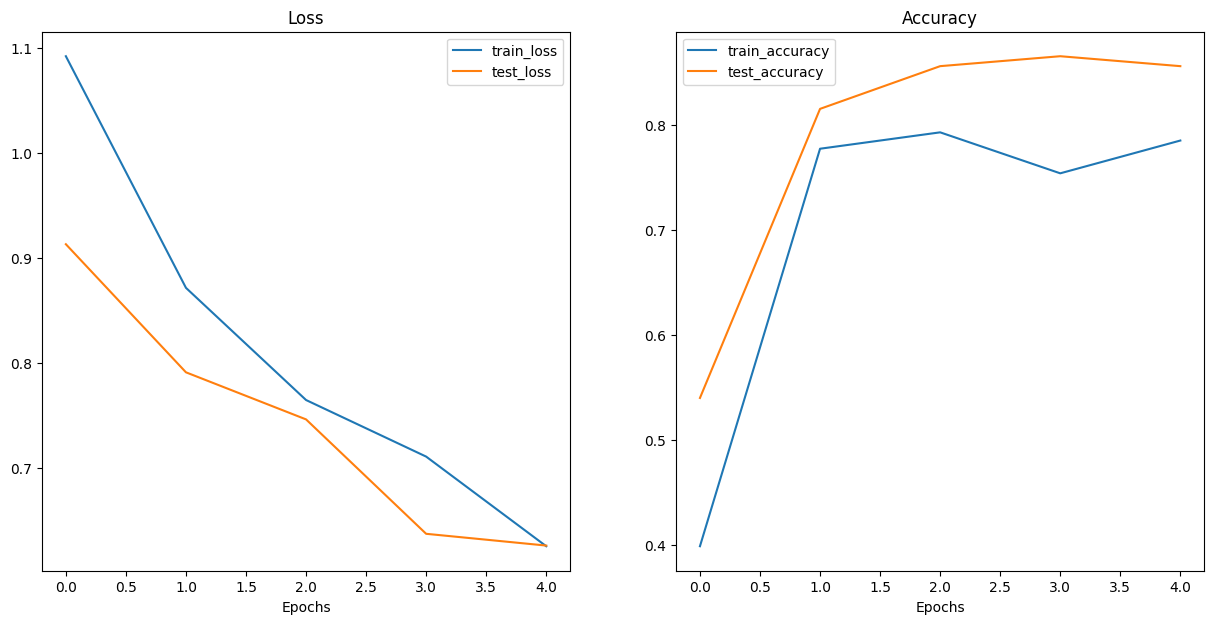

In [19]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make prediction on images fomr the test set

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

* Same shape
* Same datatype
* Same device
* Same transformation

To do all of this, we'll create a function pred_and_plot_image() to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with PIL.Image.open().
3. Create a transform for the image (this will default to the manual_transforms we created above or it could use a transform generated from weights.transforms()).
4. Make sure the model is on the target device.
5. Turn on model eval mode with model.eval() (this turns off layers like nn.Dropout(), so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with torch.unsqueeze(dim=0) so our input image has shape [batch_size, color_channels, height, width].
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with torch.softmax().
9. Convert model's prediction probabilities to prediction labels with torch.argmax().
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8.

In [20]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transfrom, device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (244, 244),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open img
  img = Image.open(image_path)

  # 3. Create transfomrtion for image(if one does not exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])

  ### Predict on image ###

  # 4. Make sure the mode is on the target deive
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transfomr and add an extra dim to image (model requires samples in [batch_size, color_channels, height, width])
    transfomred_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make a pred on image with extra dim and send it to device
    target_image_pred = model(transfomred_image.to(device))

  # 8. Logits -> pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Pred probs -> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with pred label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

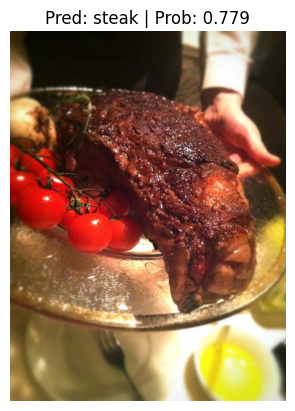

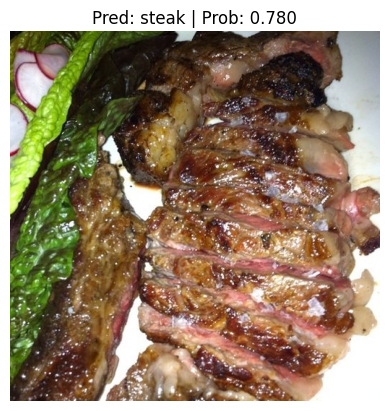

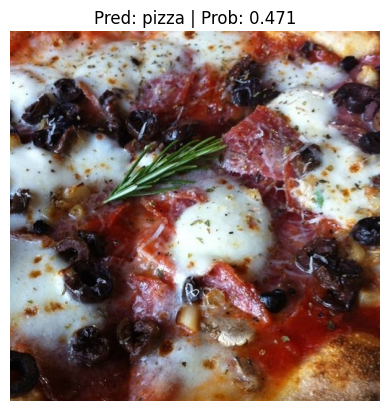

In [21]:
# Get a random list of iamge path from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # take k random images from the population

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))